## Neural network: ice velocity length

This notebook entails the process for predicting the sea ice velocity lengths (norms). The experimentation was done in Google Colab, so a few remnants of that should be visible in the code, but can be replaced easily with own folder paths or names.

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers.experimental import preprocessing

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [10]:
# load the dataset from Drive:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load from drive folder (on Google Colab)
drift_data_test = pd.read_csv('/content/drive/MyDrive/Hackathon/DRIFT_DATA_TEST.csv')
drift_data_train = pd.read_csv('/content/drive/MyDrive/Hackathon/DRIFT_DATA_TRAIN.csv')

In [ ]:
drift_data_train.head()

,year,month,day,doy,x_EASE,y_EASE,u_buoy,v_buoy,id_buoy,u_ERA5,v_ERA5,sic_CDR,h_cs2smos,h_piomas,d2c
0,1979,2,18,49,147.506958,138.582672,-0.797554,1.114740,1906,-6.704156,-0.321260,0.990195,NaN,3.189743,522.523298
1,1979,2,18,49,146.834778,120.509880,0.643200,0.368754,1913,-6.818630,-0.674205,0.966372,NaN,2.484009,412.767669
2,1979,2,18,49,130.993561,129.623672,-1.162420,0.243717,1914,-8.825469,1.123955,0.996022,NaN,2.474106,362.547379
3,1979,2,18,49,147.524719,157.382492,0.919766,0.025784,1918,-1.079951,-1.035410,0.982681,NaN,3.740522,381.025629
4,1979,2,19,50,147.470963,138.599823,0.380940,1.243485,1906,-2.169171,2.537787,0.990302,NaN,3.188522,521.535334


In [ ]:
drift_data_test.head()

,year,month,day,doy,x_EASE,y_EASE,u_buoy,v_buoy,id_buoy,u_ERA5,v_ERA5,sic_CDR,h_cs2smos,h_piomas,d2c
0,1979,2,18,49,197.656311,204.507797,NaN,NaN,NaN,5.998414,3.617303,0.987723,NaN,2.535649,375.766965
1,1979,2,19,50,197.769897,204.840912,NaN,NaN,NaN,-1.414826,-0.201038,0.964051,NaN,2.539519,370.636136
2,1979,2,19,50,147.548553,157.382889,NaN,NaN,NaN,-4.140861,3.038851,1.000000,NaN,3.746467,381.590523
3,1979,2,20,51,146.934814,120.546783,NaN,NaN,NaN,2.998362,4.055094,1.000000,NaN,2.496566,413.672796
4,1979,2,21,52,197.534439,204.845886,NaN,NaN,NaN,-8.538108,4.243983,0.978987,NaN,2.530706,376.255493


In [ ]:
drift_data_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,339478.0,2007.013774,9.822726,1979.000000,2000.000000,2009.000000,2015.000000,2019.000000
month,339478.0,6.749374,3.454148,1.000000,4.000000,7.000000,10.000000,12.000000
day,339478.0,15.744955,8.752622,1.000000,8.000000,16.000000,23.000000,31.000000
doy,339478.0,190.020314,105.562830,1.000000,101.000000,190.000000,285.000000,364.000000
x_EASE,339478.0,163.595093,24.451743,39.168983,146.809723,161.223709,181.115864,279.391541
y_EASE,339478.0,156.507375,34.697790,36.870293,129.208836,152.350731,179.608978,279.562073
u_buoy,339478.0,-0.333029,8.072700,-74.682899,-3.722860,-0.024725,2.942216,68.396103
v_buoy,339478.0,1.359709,7.860918,-66.781601,-2.325024,0.322306,4.969131,68.639801
id_buoy,339478.0,35576.107397,31444.526635,0.000000,7408.000000,26150.000000,64878.000000,99800.000000
u_ERA5,339478.0,-0.096208,4.319904,-23.084634,-3.149262,-0.165074,2.934149,17.911558


In [ ]:
date_time = pd.to_datetime(["{}.{}.{}".format(day, month, year) for day, month, year 
 in zip(drift_data_train.day, drift_data_train.month, drift_data_train.year)], format='%d.%m.%Y')

In [11]:
# include the periodicity/seasonality information from the Fourier analysis (see other notebook):
drift_data_train["year_sin"] = np.sin(drift_data_train["doy"] * (2 * np.pi / 364))
drift_data_train["year_cos"] = np.cos(drift_data_train["doy"] * (2 * np.pi / 364))

# include norm of the wind velocities as data:
drift_data_train["wind_norm"] = np.sqrt(drift_data_train["u_ERA5"].values**2 + drift_data_train["v_ERA5"].values**2)

**Train-test split:**

In [12]:
from sklearn.model_selection import train_test_split

data = drift_data_train[["year_sin", "year_cos", "wind_norm", "x_EASE",	"y_EASE",	"u_buoy",	"v_buoy",	"u_ERA5",	"v_ERA5",	"sic_CDR",	"h_piomas",	"d2c"]]

# split the data:
train, test = train_test_split(data, test_size=0.2)

**Options for the training set:**

In [13]:
# using all standard variables + sin/cos:
train_set = train[["year_sin", "year_cos", "x_EASE",	"y_EASE", "u_ERA5",	"v_ERA5",	"sic_CDR", "h_piomas",	"d2c"]].copy(deep=True)

# Experimental train_sets:
# train_set = train[["x_EASE",	"y_EASE", "u_ERA5",	"v_ERA5",	"sic_CDR",	"h_piomas",	"d2c"]]  # no forced seasonality
# train_set = train[["year_sin", "year_cos", "wind_norm", "x_EASE",	"y_EASE", "u_ERA5",	"v_ERA5",	"sic_CDR",	"h_piomas",	"d2c"]]  # add wind_norm
# train_set = train[["year_sin", "year_cos", "wind_norm", "x_EASE",	"y_EASE",	"sic_CDR",	"h_piomas",	"d2c"]]  # only windnorm, no x, y components
# train_set = train[["u_ERA5",	"v_ERA5"]]  # check relationship by using only the wind velocities

# Using both outputs, U and V:
# train_labels = train[["u_buoy",	"v_buoy"]]

# Using only the norm as output:
train_labels = np.sqrt(train["u_buoy"].values**2 + train["v_buoy"].values**2)

**Same options for the test set:**

In [14]:
test_set = test[["year_sin", "year_cos", "x_EASE",	"y_EASE", "u_ERA5",	"v_ERA5",	"sic_CDR",	"h_piomas",	"d2c"]].copy(deep=True)
# test_set = test[["x_EASE",	"y_EASE", "u_ERA5",	"v_ERA5",	"sic_CDR",	"h_piomas",	"d2c"]]
# test_set = test[["year_sin", "year_cos", "wind_norm", "x_EASE",	"y_EASE", "u_ERA5",	"v_ERA5",	"sic_CDR",	"h_piomas",	"d2c"]]
# test_set = test[["year_sin", "year_cos", "wind_norm", "x_EASE",	"y_EASE", "sic_CDR",	"h_piomas",	"d2c"]]
# test_set = test[["u_ERA5",	"v_ERA5"]]

# test_labels = test[["u_buoy",	"v_buoy"]]
test_labels = np.sqrt(test["u_buoy"].values**2 + test["v_buoy"].values**2)

**Building the neural network model**

In [15]:
# normalization of input variables:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_set))

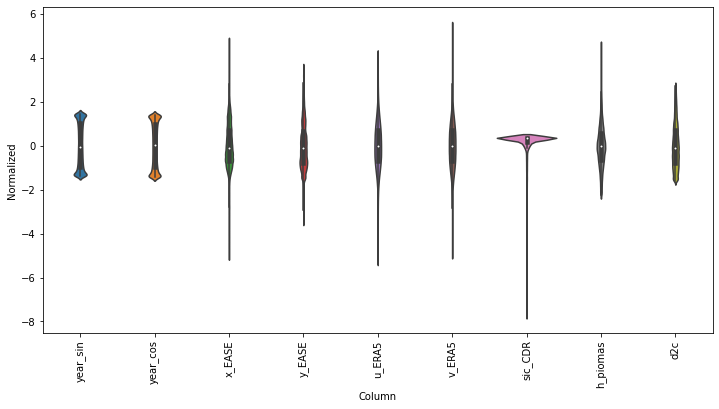

In [16]:
# visualize normalized data ranges:
df_std = pd.DataFrame(np.array(normalizer(train_set))).melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(train_set.keys(), rotation=90)

We center the outputs as well for better performance. It's important to note that the outputs of the neural network afterwards need to be decentered with '`+ norm_mean`' afterwards for sensible predictions!

In [17]:
norm_mean = np.mean(train_labels)
norm_stdev = np.std(train_labels)
print(norm_mean)
print(norm_stdev)

train_labels = (train_labels - norm_mean)
test_labels = (test_labels - norm_mean)

8.350506078212343
7.673665386674215


We build the custom root mean square loss function that is specified as the criterion by Charles Brunette:

In [18]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [19]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        normalizer,
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1),
    ])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss=root_mean_squared_error,
    # loss="mse"
    )

**All right, let's train!**

In [ ]:
history = model.fit(
    x=train_set, y=train_labels,
    epochs=100,
    verbose=1,
    validation_split=0.2
    )

Let's test our trained model on our held-out test samples:

In [21]:
test_predictions = model.predict(test_set)

Calculate the root mean square error, the mean absolute error and the mean error:

In [22]:
### for norms with scaled outputs:
preds = np.array(test_predictions).flatten() + norm_mean

rmse_errors = []
mae_errors = []
me_errors = []
for i, pred in enumerate(preds):
  mae_errors.append(np.abs(pred - (test_labels[i] + norm_mean)))
  me_errors.append(pred - (test_labels[i] + norm_mean))
  rmse_errors.append((pred - (test_labels[i] + norm_mean))**2)

print("rmse: ", np.sqrt(np.mean(rmse_errors)))
print("mae: ", np.mean(mae_errors))
print("me: ", np.mean(me_errors))

rmse:  4.324381972107585
mae:  2.8158855641337275
me:  -0.1112000423352805


## Submission test

The following code is for inferencing on the actual test set for which we don't have labels (i.e., the one we have to submit):

In [ ]:
# include the periodicity/seasonality information from the Fourier analysis:
drift_data_test["year_sin"] = np.sin(drift_data_test["doy"] * (2 * np.pi / 364))
drift_data_test["year_cos"] = np.cos(drift_data_test["doy"] * (2 * np.pi / 364))

actual_test_set = drift_data_test[["year_sin", "year_cos", "x_EASE",	"y_EASE", "u_ERA5",	"v_ERA5",	"sic_CDR",	"h_piomas",	"d2c"]].copy(deep=True)

In [ ]:
actual_test_predictions = model.predict(actual_test_set)
actual_test_predictions = np.array(actual_test_predictions + norm_mean)

Let's write our predictions to disk and download them:

In [ ]:
write_away = drift_data_test.drop(["year_sin", "year_cos"], axis=1)
write_away["vector_length_pred"] = actual_test_predictions
write_away.to_csv("predictions.csv")

Let's download the model as well:

In [ ]:
model.save('/content/')

In [ ]:
!zip -r /content/variables.zip /content/variables

**Let's compare our results with the baseline of always picking the average length:**

In [ ]:
# "predictor" predicting always 8.35 for the norm
preds_avg = np.ones(len(preds)) * 8.35

rmse_errors = []
mae_errors = []
for i, pred in enumerate(preds_avg):
  mae_errors.append(np.abs(pred - test_labels[i]))
  rmse_errors.append((pred - test_labels[i])**2)

print("rmse: ", np.sqrt(np.mean(rmse_errors)))
print("mae: ", np.mean(mae_errors))

**Code for using the U and V as outputs and calculating the errors**

In [ ]:
### calculating the errors on the norm:
preds = np.array(test_predictions)

rmse_errors = []
mae_errors = []
for i, pred in enumerate(preds):
  mae_errors.append(np.abs(np.linalg.norm(pred) - np.linalg.norm(test_labels.values[i])))
  rmse_errors.append((np.linalg.norm(pred) - np.linalg.norm(test_labels.values[i]))**2)

print("rmse: ", np.sqrt(np.mean(rmse_errors)))
print("mae: ", np.mean(mae_errors))

In [ ]:
def convert_to_degrees(angles):
  return np.array(angles) * 360 / (2 * np.pi)

In [ ]:
# calculating the errors on the angles:
preds = np.array(test_predictions)

angles = []
angle_errors = []
for i, pred in enumerate(preds[:]):
  U_i_norm = pred / np.linalg.norm(pred)

  U_i_true = test[["u_buoy",	"v_buoy"]].values[i]
  if not np.isclose(np.linalg.norm(U_i_true), 0):
    U_i_true_norm = U_i_true / np.linalg.norm(U_i_true)

    U_a = test[["u_ERA5",	"v_ERA5"]].values[i]
    U_a_norm = U_a / np.linalg.norm(U_a)

    dot_product_pred = np.clip(np.dot(U_i_norm, U_a_norm), -0.9999, 0.9999)
    dot_product_true = np.clip(np.dot(U_i_true_norm, U_a_norm), -0.9999, 0.9999)

    pred_angle = np.arccos(dot_product_pred)
    true_angle = np.arccos(dot_product_true)
    angles.append(pred_angle)
    angle_errors.append(np.abs(pred_angle - true_angle))

In [ ]:
degrees = convert_to_degrees(angles)
print("mean angle: ", np.mean(degrees))
print("rmse: ", np.sqrt(np.mean(convert_to_degrees(angle_errors)**2)))
print("mae: ", np.mean(convert_to_degrees(angle_errors)))